Epoch 0: Loss = 4615.09326, r = 0.00000
Epoch 500: Loss = 179.18393, r = -0.00004
Epoch 1000: Loss = 179.13768, r = 0.00017
Epoch 1500: Loss = 141.94638, r = 0.68338
Epoch 2000: Loss = 20.66809, r = 3.36728
Epoch 2500: Loss = 7.99282, r = 4.35398
Epoch 3000: Loss = 1.63173, r = 4.76929
Epoch 3500: Loss = 0.39908, r = 4.94326
Epoch 4000: Loss = 0.31072, r = 5.01492
Epoch 4500: Loss = 0.37815, r = 5.04665


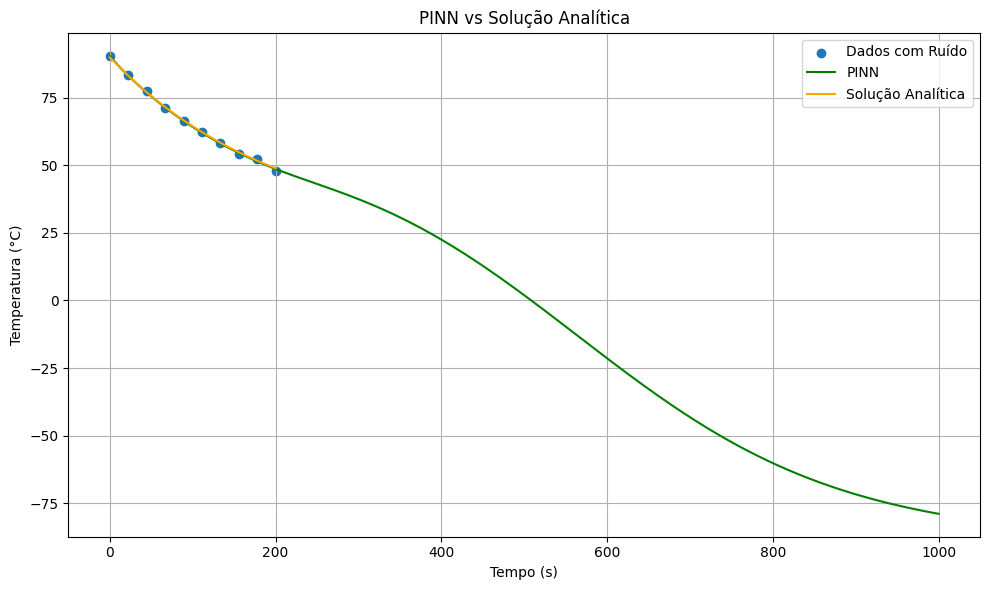


Valor de r descoberto pela PINN: 5.06141


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Dados sintéticos
t_train = torch.linspace(0, 200, 10).view(-1, 1)
T0 = 90
T_amb = 25
r_true = 0.005
T_train_true = T_amb + (T0 - T_amb) * torch.exp(-r_true * t_train)
noise = torch.normal(0.0, 0.5, size=T_train_true.shape)
T_train_noisy = T_train_true + noise

# Normalização
t_norm = t_train / 1000

# PINN model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh(),
            nn.Linear(32, 1)
        )
        self.r = nn.Parameter(torch.tensor([0.01]))  # r será aprendido

    def forward(self, t):
        return self.net(t)

    def physics_loss(self, t):
        t.requires_grad = True
        T = self.net(t)
        dTdt = torch.autograd.grad(T, t, grad_outputs=torch.ones_like(T), create_graph=True)[0]
        loss_phys = ((dTdt + self.r * (T - T_amb))**2).mean()
        return loss_phys

# Treinamento
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.01)

for epoch in range(5000):
    optimizer.zero_grad()
    pred = model(t_norm)
    loss_data = nn.MSELoss()(pred, T_train_noisy)
    loss_phys = model.physics_loss(t_norm)
    loss_total = loss_data + loss_phys
    loss_total.backward()
    optimizer.step()
    if epoch % 500 == 0:
        print(f"Epoch {epoch}: Loss = {loss_total.item():.5f}, r = {model.r.item():.5f}")

# Avaliação
t_test = torch.linspace(0, 1000, 500).view(-1, 1) / 1000
with torch.no_grad():
    T_pred = model(t_test).view(-1).numpy()

plt.figure(figsize=(10, 6))
plt.scatter(t_train.numpy(), T_train_noisy.numpy(), label="Dados com Ruído")
plt.plot(t_test.numpy() * 1000, T_pred, label="PINN", color="green")
plt.plot(t_train.numpy(), T_train_true.numpy(), label="Solução Analítica", color="orange")
plt.xlabel("Tempo (s)")
plt.ylabel("Temperatura (°C)")
plt.title("PINN vs Solução Analítica")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print(f"\nValor de r descoberto pela PINN: {model.r.item():.5f}")

# ------------
